# Integrantes

* Angelo Rossi - RM365902
* Carlos Eduardo Arlindo - RM365213
* Felipe Goiabeira - RM365753
* Guilherme Groff - RM365281
* Rafael Lua - RM366254

In [5]:
#IMPORTAÇAO DE BIBLIOTECAS
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

import seaborn as sns

import warnings

#DESATIVA AVISOS.
warnings.filterwarnings(action='ignore')

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
def print_feature_distribution(dataset, feature_name):
    histogram = px.histogram(dataset, x=feature_name, color="diagnostico", marginal="box")
    histogram.update_layout(bargap=0.2, bargroupgap=0.1, yaxis_title='Count',
                            title=f'Histograma de {feature_name} por diagnostico')
    histogram.show()

# Formato da base de dados

## Sobre

Todos os pacientes são mulheres com pelo menos 21 anos e de ascendência indígena Pima.

## 1. Análise exploratória dos dados (EDA):

Importar base de dados

In [ ]:
import kagglehub
import pandas as pd
import os

#BAIXANDO O ARQUIVO
path = kagglehub.dataset_download("mathchi/diabetes-data-set")

print("Dataset downloaded to:", path)

#CAMINHO DO ARQUIVO DO DATA SET
csv_path = os.path.join(path, "diabetes.csv")

#CARREGANDO O DATA SET
original_dataset = pd.read_csv(csv_path)

print("Formato:", original_dataset.shape)


Dataset downloaded to: C:\Users\guilh\.cache\kagglehub\datasets\mathchi\diabetes-data-set\versions\1
Formato: (768, 9)


Informações básicas sobre a base de dados

In [ ]:
#IMPRIME INFORMAÇÕES DO DATASET
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Em análise inicial vemos que o dataset tem o formato de tabela com 768 registros com 9 colunas sendo que, nenhuma do tipo texto.

In [ ]:
#IMPRIME AS PRIMEIRAS 5(DEFAULT) LINHAS DO DATASET
original_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**O dataset é composto pelas colunas:**
* Pregnancies: Número de vezes grávida
* Glucose: Concentração de glicose plasmática a 2 horas num teste de tolerância oral à glicose
* BloodPressure: Pressão arterial diastólica (mm Hg)
* SkinThickness: Espessura da prega cutânea do tríceps (mm)
* Insulin: Insulina sérica de 2 horas (mu U/ml)
* BMI: Índice de massa corporal (peso em kg/(altura em m)^2)
* diabétesPedigreeFunction: Função de pedigree do diabétes
* Age: Idade (anos)
* Outcome (variável target): Variável de classe (0 ou 1)


Teremos como variável "target" a coluna "Outcome".

In [ ]:
#TRANSPÕE AS COLUNAS EM LINHA E NOS APRESENTA ESTATÍTICAS BASICAS DE CADA UMA DELAS.
original_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Para fácilitar a leitura iremos modificar o nome das colunas.

Vamos traduzir os nomes

In [ ]:
original_dataset.columns = [
    'gravidez',
    'glicose',
    'pressao_arterial',
    'espessura_pele',
    'insulina',
    'imc',
    'historico_familiar_diabetes',
    'idade',
    'diagnostico'
]

Dataset com as colunas renomeadas

In [ ]:
#IMPRIME ESTATÍSTICAS DESCRITIVAS DE CADA COLUNA
original_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
gravidez,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
glicose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
pressao_arterial,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
espessura_pele,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
insulina,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
imc,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
historico_familiar_diabetes,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
idade,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
diagnostico,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


### 1.1 Verificando a existencia de valores nulos

In [ ]:
#SOMA QUANTIDADE DE DADOS NULOS POR CAMPO/COLUNA
original_dataset.isnull().sum()

gravidez                       0
glicose                        0
pressao_arterial               0
espessura_pele                 0
insulina                       0
imc                            0
historico_familiar_diabetes    0
idade                          0
diagnostico                    0
dtype: int64

Ná análise demonstrada acima, o dataset não demonstra ter valor nulo.

OBS: Valores Nulos != Valores zerados



### 1.2 Distribuição dos Dados

#### 1.2.1 Distribuição da variável target (Diagnóstico)

In [ ]:
#SOMATÓRIA DE DADOS, E CONTAGEM DE CADA DIAGNÓSTICO
total = len(original_dataset)
diabetics = original_dataset[original_dataset['diagnostico'] == 1].diagnostico.count()
non_diabetics = original_dataset[original_dataset['diagnostico'] == 0].diagnostico.count()

print(f"Total de registros: {total}")
print(f"Diabeticos: {diabetics} - {100 * diabetics / total:.2f}% do total de registros")
print(f"Não Diabeticos: {non_diabetics} - {100 * non_diabetics / total:.2f}% do total de registros")

Total de registros: 768
Diabeticos: 268 - 34.90% do total de registros
Não Diabeticos: 500 - 65.10% do total de registros


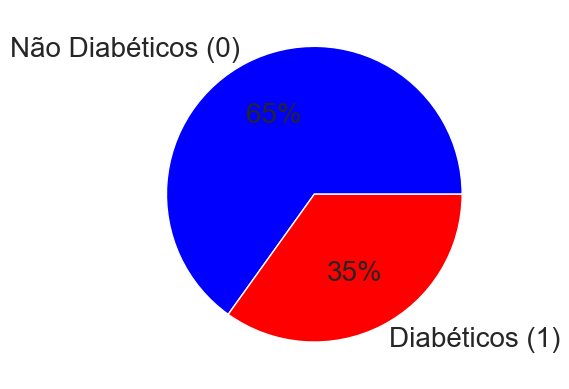

diagnostico                           0           1
gravidez                       3.298000    4.865672
glicose                      109.980000  141.257463
pressao_arterial              68.184000   70.824627
espessura_pele                19.664000   22.164179
insulina                      68.792000  100.335821
imc                           30.304200   35.142537
historico_familiar_diabetes    0.429734    0.550500
idade                         31.190000   37.067164


In [ ]:
colors = ['blue', 'red']
labels = ['Não Diabéticos (0)', 'Diabéticos (1)']

#PLOTAGEM DO GRÁFICO DE PIZZA
plt.pie(original_dataset['diagnostico'].value_counts(), labels=labels, colors=colors, autopct='%1.0f%%',
        textprops={'fontsize': 20})
plt.show()
print(original_dataset.groupby("diagnostico").mean().T)

#### 1.2.1 Distribuição das features por target

##### 1.2.1.1 Feature Gravidez

In [ ]:
#EXIBE GRÁFICO DE BARRAS
print_feature_distribution(original_dataset, 'gravidez')

Histograma de diagnósticos de diabetes relacionado ao número de vezes que a paciente engravidou. Em vermelho os pacientes saudáveis, em azul aqueles diagnosticados com diabetes.

Observa-se que, até a 6ª gravidez, o número de mulheres saudáveis era maior que o número de mulheres diabéticas. A partir da 7ª, o número de mulheres diagnosticadas com diabetes se torná levemente maior (desconsiderando a 10ª gravidez, que apresenta um número similar). A partir da 13ª, todos os pacientes avaliados apresentaram diabetes.  


##### 1.2.1.2 Feature Glicose

In [ ]:
print_feature_distribution(original_dataset, 'glicose')

Histograma de níveis de glicose relacionado ao diagnóstico de diabetes. Em vermelho os pacientes saudáveis, em azul aqueles diagnosticados com diabetes.

Ao analisar o histograma, observa-se a presença de valores de Glicose zerados. Tais valores são considerados inválidos, visto que ilustram cenários impossíveis para pacientes considerados tanto diabéticos quanto saudáveis. Estes valores serão ajustados futuramente a partir da substituição dos dados pela mediana.

Levando em consideração as outras características do histograma, evidencia-se a presença de pacientes diabéticos apenas a partir da faixa 75-79. Ao que indica em uma análise inicial, o número de pessoas diagnosticados com a doença aumenta proporcionalmente ao valor da glicose do paciente, alcançando a maioria dos
indivíduos a partir de 155. Com base em tal constatação, a glicose pode ter uma relação direta com o diagnóstico de diabetes.

##### 1.2.1.3 Feature Pressão Arterial

In [ ]:
print_feature_distribution(original_dataset, 'pressao_arterial')

Histograma de pressão arterial relacionado ao diagnóstico de diabetes. Em vermelho os pacientes saudáveis, em azul aqueles diagnosticados com diabetes.

Em uma primeira análise do histograma, observa-se a presença de valores zerados na pressão arterial. Tais informações são consideradas inválidas, visto que demonstram uma situação impossível aos pacientes, tanto diabéticos quanto saudáveis. Estes valores serão tratados em análises futuras a partir da substituição dos dados pela mediana.

O gráfico demonstra que, apesar do número elevado de pressão arterial, o número de pacientes diabéticos é menor que a quantidade de saudáveis independente da pressão (desconsiderando algumas raras vezes nos intervalos entre 100-104mmHG e 110-114mmHG). Ao que indica, a pressão arterial não demonstra uma relação tão expressiva para o diagnóstico de diabetes.


##### 1.2.1.4 Feature Espessura da Pele

In [ ]:
print_feature_distribution(original_dataset, 'espessura_pele')

Histograma de espessura da pele relacionada ao diagnóstico de diabetes. Em vermelho os pacientes saudáveis, em azul aqueles diagnosticados com diabetes.

De primeira vista, observa-se uma quantidade exorbitante de valores inválidos na espessura da pele. Devido a se demonstrarem zerados, ilustram um cenário impossível aos pacientes tanto saudáveis quanto diagnosticados com a doença, e por conta disso, serão tratados em análises futuras a partir de uma substituição dos dados pela mediana.
Em uma análise inicial, o histograma demonstra que o número dos diagnosticados com diabetes aumenta proporcionalmente à espessura da pele em relação aos pacientes saudáveis. Após a faixa de 45-49mm, chegam a superar o número de saudáveis, porém, não se mantém na mesma proporção. Isso pode indicar a não relação direta entre a espessura da pele e o diagnóstico de diabetes.


##### 1.2.1.5 Feature Insulina

In [ ]:
print_feature_distribution(original_dataset, 'insulina')

Histograma de insulina relacionada ao diagnóstico de diabetes. Em vermelho os pacientes saudáveis, em azul aqueles diagnosticados com diabetes.

Assim como na espessura de pele, observa-se uma grande quantidade de leituras zeradas consideradas impossíveis para o cenário. Tais valores serão tratados pela mediana para não interferir em futuras análises.

O histograma também demonstra um aumento na quantidade de usuários diagnosticados com diabétes entre as faixas 100 a 200mu U/ml. Tal constatação leva a indicar uma possivel relação entre o aumento de insulina e a presença diabétes, porém, devido ao alto número de valores invalidos, torna-se díficil estabelecer uma conexão concisa.  


##### 1.2.1.6 Feature IMC

In [ ]:
print_feature_distribution(original_dataset, 'imc')

Histograma de IMC relacionado ao diagnóstico de diabetes. Em vermelho os pacientes saudáveis, em azul aqueles diagnosticados com diabetes.

Apesar do gráfico também demonstrar a presença de valores inválidos, acredita-se que não são em uma quantidade grande o suficiente para afetar a distribuição dos dados.

Em uma análise inicial do histograma, a maior proporção de diagnósticos positivos para diabetes atinge o ápice na faixa entre 31 e 32.9, mas logo em seguida começa a reduzir. Isso pode indicar a não relação direta entre o IMC e pacientes diabéticos, porém, o número de pacientes saudáveis é consideravelmente maior em IMCs mais baixos. Embora não relacionado diretamente, pacientes com IMC maiores demonstram mais chances de desenvolverem diabetes.


##### 1.2.1.7 Feature Idade

In [ ]:
print_feature_distribution(original_dataset, 'idade')

Histograma de Idade relacionado ao diagnóstico de diabetes. Em vermelho os pacientes saudáveis, em azul aqueles diagnosticados com diabetes.

As leituras de idade não possuem valores inválidos.

Em uma análise inicial do gráfico, observa-se uma distribuição de pacientes diabéticos mais presente em idades avançadas, enquanto os saudáveis demonstram uma maior presença na juventude. A partir de tal constatação, é possível inferir a correlação entre idade e diabetes, sendo quanto mais velho, maior a chance de desenvolver a doença.


#### 1.2.2 Correlação entre Glicose e Insulina

Devido o comportamento similar entre as features de insulina e glicose no diagnostico de diabétes, vamos analisar como as duas se relacionam

In [ ]:
#PLOTAGEM DO GRÁFICO
scatter = px.scatter(original_dataset, x='insulina', y='glicose', color='glicose', trendline="ols")
scatter.update_layout(margin=dict(t=0, b=0, l=0, r=0), title='Distribuição de glicose por insulina')
scatter.show()

Embora se tenha a presença de valores inválidos para glicose e insulina, podemos notar que a linha de tendência mostra uma relação direta ente a leitura de insulina e a leitura de glicose, isso mostra que ambos tem relação de influência direta no diagnóstico de diabétes.

As features onde o valor é igual a zero e são invalidas:

* Glicose
* Pressão Arterial
* Espessura da Pele
* Insulina

As features de Insulina e Espessura da Pele tem a distribuição dos seus dados afetados pelo grande número de medições inválidas presente na pele, isso é perceptivel pelo limite inferior e o primeiro Quartil estarem igualados em zero.

Embora nas outras features os valores iguais a 0 são marcadas como outliers pelos diagramas de Caixa, o cálculo da distribuição dos dados ainda pode ser afetado por eles.

Antes de verificarmos se tratar esses valores inválidos modificará a distribuição dos dados, devemos analisar a correlação atual entre as features e o diagnóstico de diabétes do paciente.

### 1.3 Correlação entre as features

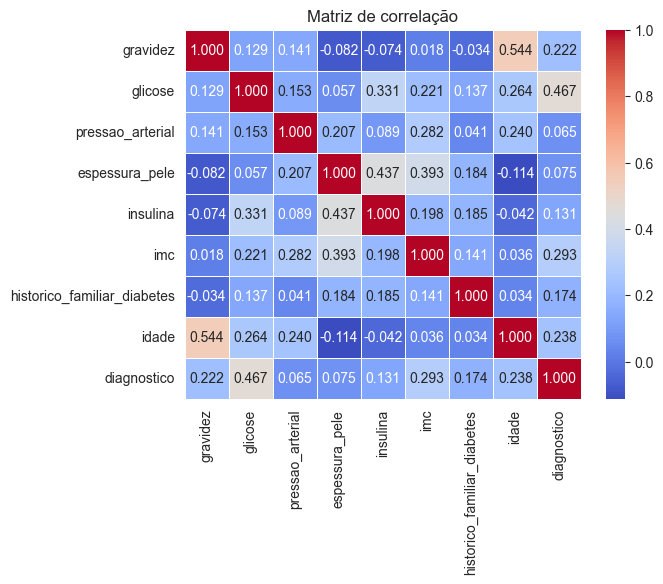

In [ ]:

#IMPRIME MATRIZ DE CORRELAÇÃO
def print_features_correlation(dataset):
    dataset_correlation = dataset.corr()
    sns.heatmap(data=dataset_correlation, annot=True, linewidths=.5, fmt=".3f", cmap="coolwarm")
    plt.title("Matriz de correlação")
    plt.show()


print_features_correlation(original_dataset)

**Analise do gráfico de calor**

Uma tabela de correlação é uma forma bem útil de visualizar a relação entre variáveis quantitativas. Quanto mais próxima do zero, menor é a correlação entre as duas colunas analisadas. Ao se aproximar de 1 ou -1, a relação é considerada mais forte, tornando-se positiva ou negativa.

Se o valor estiver próximo a 1, a correlação é positiva: quanto maior for uma das variáveis, maior a tendência da outra também apresentar valores mais altos. Na imagem acima, tal comportamento é observado nas colunas de Age x Pregnancies (0.54) e Glicose x Outcome (0.47). Ou seja, em uma análise inicial, quanto mais velhas as mulheres, maior a chance de terem engravidado durante a vida, e quanto maior o nível de glicose no sangue, maior a chance de terem sido diagnosticadas com diabétes.

Se o valor estiver próximo a -1, a correlação é negativa: quanto maior for uma das variáveis, maior a tendência da outra diminuir o seu valor. No entanto, na imagem acima não se demonstram exemplos que evidenciem esse comportamento, pois o valor mais próximo de -1 é observado entre as colunas Age x SkinThickness (-0.11), o que indica uma correlação muito fraca e provavelmente irrelevante.

Analisando o gráfico de calor, mesmo com valores inválidos em algumas features, é possível constatar:

* A principal feature é a **Glicose** com 0,467;
* Seguido pelo **IMC** (0,293) e a **idade** (0,238);
* As features com menor influência são: **pressão arterial** (0,065) e **espessura da pele** (0,075)


### 1.4 Tratamento de valores inválidos

A presença de valores inválidos em algumas features não foi grande o suficiente ao ponto de alterar a distribuição dos dados. Vamos remove-los para averiguar o impacto que eles tem sobre a relação de cada feature com o diagnóstico de diabétes.

In [ ]:
total_features = len(original_dataset)

#PERCORRE O DATASET E IMPRIME QUANTIDADE DE VALORES "ZERADOS"
for feature in original_dataset.columns[:-1]:
    zero_count = original_dataset[original_dataset[feature] == 0][feature].count()
    percentage = 100 * zero_count / total_features
    print(f"{feature} com valor zero: {zero_count} ({percentage:.2f}% do total de registros)")

gravidez com valor zero: 111 (14.45% do total de registros)
glicose com valor zero: 5 (0.65% do total de registros)
pressao_arterial com valor zero: 35 (4.56% do total de registros)
espessura_pele com valor zero: 227 (29.56% do total de registros)
insulina com valor zero: 374 (48.70% do total de registros)
imc com valor zero: 11 (1.43% do total de registros)
historico_familiar_diabetes com valor zero: 0 (0.00% do total de registros)
idade com valor zero: 0 (0.00% do total de registros)


Para verificar a influência dos valores inválidos no diagnóstico de diabétes, foram utilizadas as estratégias:

* Substituir os valores inválidos pela mediana dos valores válidos de cada feature
* Substituir os valores inválidos pela mediana dos valores válidos de cada feature do diagnóstico correspondente

#### 1.4.1 Substituição dos valores inválidos pela mediana das features

In [ ]:
dataset_without_invalid_values = original_dataset.copy()

#PERCORRE CADA COLUNA E SUBSTITUE OS VALORES INVÁLIDOS PELA MEDIANA DA PRÓPRIA COLUNA
for feature in dataset_without_invalid_values.columns[:-1]:
    no_zero_median = dataset_without_invalid_values[feature][dataset_without_invalid_values[feature] != 0].median()
    dataset_without_invalid_values[feature] = dataset_without_invalid_values[feature].replace(0, no_zero_median)

dataset_without_invalid_values.describe()

,gravidez,glicose,pressao_arterial,espessura_pele,insulina,imc,historico_familiar_diabetes,idade,diagnostico
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,4.423177,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,2.980481,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,1.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,2.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,4.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### 1.4.2 Substituição dos valores inválidos pela mediana das feature estratificada por diagnóstico

In [ ]:
dataset_median_per_outcome = original_dataset.copy()

for feature in dataset_median_per_outcome.columns[:-1]:
    for target_class in dataset_median_per_outcome['diagnostico'].unique():
        median = dataset_median_per_outcome[
            (dataset_median_per_outcome['diagnostico'] == target_class) & (dataset_median_per_outcome[feature] != 0)][
            feature].median()
        condition = (dataset_median_per_outcome['diagnostico'] == target_class) & (
                    dataset_median_per_outcome[feature] == 0)
        dataset_median_per_outcome.loc[condition, feature] = median

dataset_median_per_outcome.describe()

,gravidez,glicose,pressao_arterial,espessura_pele,insulina,imc,historico_familiar_diabetes,idade,diagnostico
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,4.377604,121.677083,72.389323,29.089844,141.753906,32.434635,0.471876,33.240885,0.348958
std,3.010736,30.464161,12.106039,8.890820,89.100847,6.880498,0.331329,11.760232,0.476951
min,1.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,2.000000,99.750000,64.000000,25.000000,102.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.000000,102.500000,32.050000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,169.500000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### 1.4.3 Comparação dos dados tratados

##### 1.4.3.1 Distribuição dos dados

###### 1.4.3.1.1 Feature Glicose

In [ ]:
print('Dataset original')
print_feature_distribution(original_dataset, 'glicose')
print('Dataset com a mediana de cada feature')
print_feature_distribution(dataset_without_invalid_values, 'glicose')
print('Dataset com a mediana de cada feature por diagnóstico')
print_feature_distribution(dataset_median_per_outcome, 'glicose')

Dataset original


Dataset com a mediana de cada feature


Dataset com a mediana de cada feature por diagnóstico


Com a remoção dos valores de glicose inválidos agora só se tem a presença de um outlier abaixo do limite mínimo dos pacientes sem diabétes. A distribuição dos dados exibido pelo diagrama de caixa se mantém similar ao do dataset com valores inválidos.

Substituir os dados inválidos usando a mediana da feature ou a mediana da feature por diagnóstico não apresentou uma diferença perceptivel na distribuição dos dados.

###### 1.4.3.1.2 Feature Pressão Arterial

In [ ]:
print('Dataset original')
print_feature_distribution(original_dataset, 'pressao_arterial')
print('Dataset com a mediana de cada feature')
print_feature_distribution(dataset_without_invalid_values, 'pressao_arterial')
print('Dataset com a mediana de cada feature por diagnóstico')
print_feature_distribution(dataset_median_per_outcome, 'pressao_arterial')

Dataset original


Dataset com a mediana de cada feature


Dataset com a mediana de cada feature por diagnóstico


Com a remoção dos valores de Pressão Arterial inválidos, podemos ver que a distribuição dos dados mostrou 3 outliers abaixo do limite mínimo nos pacientes não diabéticos. Os outliers acima do limite máximo de pacientes saudáveis se manteve.

Enquanto na distribuição de pacientes diabéticos, agora temos apenas duas ocorrências de outliers abaixo do límite mínimo e houve um aumento no número de outliers acima do limite máximo.

A diferença entre as abordagens de tratamento dos dados resultou na mudança da mediana na distribuição dos dados, os demais elementos continuaram iguais

###### 1.4.3.1.3 Feature Espessura da Pele

In [ ]:
print('Dataset original')
print_feature_distribution(original_dataset, 'espessura_pele')
print('Dataset com a mediana de cada feature')
print_feature_distribution(dataset_without_invalid_values, 'espessura_pele')
print('Dataset com a mediana de cada feature por diagnóstico')
print_feature_distribution(dataset_median_per_outcome, 'espessura_pele')

Dataset original


Dataset com a mediana de cada feature


Dataset com a mediana de cada feature por diagnóstico


A substituição dos valores inválidos pela mediana da feature resultou em uma distribuição dos dados com a mesma mediana, apresentando tanto os pacientes com e sem diabétes tendo a mesma espessura de pele. No caso, os pacientes diabéticos no gráfico de caixa tiveram o primeiro quartil sobreposto com a mediana dos dados.

Já na substituição dos valores inválidos pela mediana com base no tipo de diagnóstico resultou em uma distribuição diferente, com a mediana da espessura da pele dos diabéticos sendo maior do que a dos pacientes não diabéticos. Essa estratégia também apresentou um número maior de outliers acima e abaixo dos limites minimo e máximo da distribuição.

Isso indica que a espessura da pele poderia ser usada para o diagnóstico de diabétes.

###### 1.4.3.1.3 Feature Insulina

In [ ]:
print('Dataset original')
print_feature_distribution(original_dataset, 'insulina')
print('Dataset com a mediana de cada feature')
print_feature_distribution(dataset_without_invalid_values, 'insulina')
print('Dataset com a mediana de cada feature por diagnóstico')
print_feature_distribution(dataset_median_per_outcome, 'insulina')

Dataset original


Dataset com a mediana de cada feature


Dataset com a mediana de cada feature por diagnóstico


O impacto dos valores inválidos na insulina também era bem grande, isso é perceptível pelos gráficos de caixa.

No conjunto de dados original a distribuição iniciava em zero, portanto não mostrava nenhum outlier abaixo do limite inferior em nenhum dos diagnósticos.

Em ambos os tratamentos aplicados para os valores inválidos podemos ver que existem diversos outliers acima e abaixo dos limites inferior e superior no conjunto de pacientes diabéticos.



###### 1.4.3.1.5 Feature IMC

In [ ]:
print('Dataset original')
print_feature_distribution(original_dataset, 'imc')
print('Dataset com a mediana de cada feature')
print_feature_distribution(dataset_without_invalid_values, 'imc')
print('Dataset com a mediana de cada feature por diagnóstico')
print_feature_distribution(dataset_median_per_outcome, 'imc')

Dataset original


Dataset com a mediana de cada feature


Dataset com a mediana de cada feature por diagnóstico


No caso do IMC, o uso da mediana da feature por diagnostico mostra que há um aumento no número de pacientes com diabétes se tiverem IMC acima de 30.

Para ressaltar tal constatação, observa-se que o Limite inferior do diagrama de caixas para os pacientes com diabetes se inicia no valor 30.

##### 1.4.3.2 Correlação entre as features

Dataset original


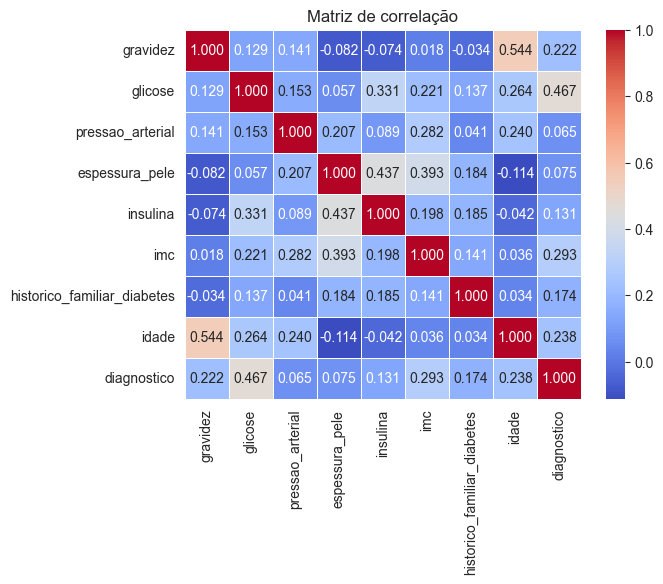

diagnostico                           0           1
gravidez                       3.298000    4.865672
glicose                      109.980000  141.257463
pressao_arterial              68.184000   70.824627
espessura_pele                19.664000   22.164179
insulina                      68.792000  100.335821
imc                           30.304200   35.142537
historico_familiar_diabetes    0.429734    0.550500
idade                         31.190000   37.067164
Dataset com a mediana de cada feature


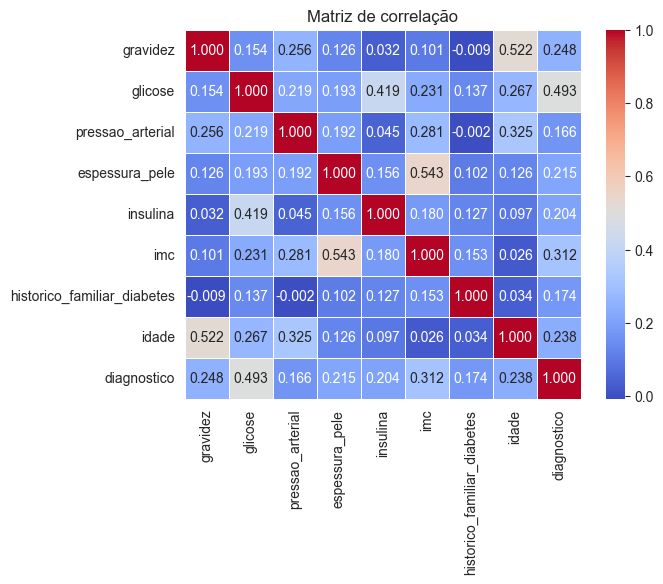

diagnostico                           0           1
gravidez                       3.882000    5.432836
glicose                      110.682000  142.130597
pressao_arterial              70.920000   75.123134
espessura_pele                27.726000   31.686567
insulina                     127.792000  164.701493
imc                           30.885600   35.383582
historico_familiar_diabetes    0.429734    0.550500
idade                         31.190000   37.067164
Dataset com a mediana de cada feature estratificado diagnóstico


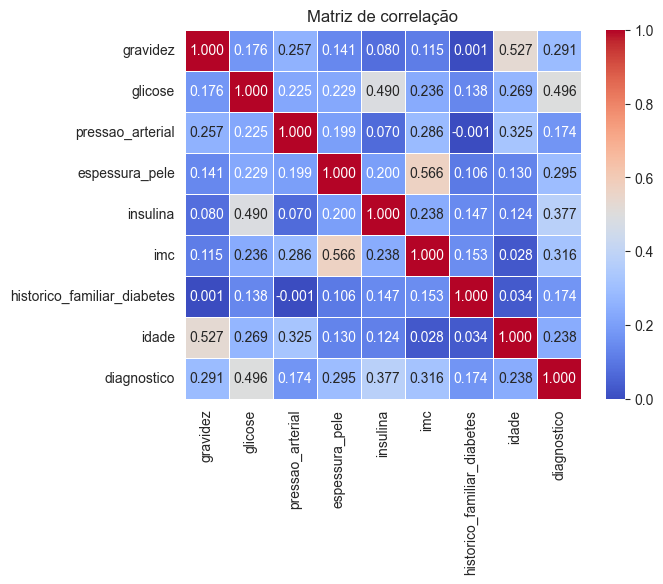

diagnostico                           0           1
gravidez                       3.736000    5.574627
glicose                      110.622000  142.302239
pressao_arterial              70.844000   75.272388
espessura_pele                27.170000   32.671642
insulina                     117.172000  187.615672
imc                           30.846000   35.398507
historico_familiar_diabetes    0.429734    0.550500
idade                         31.190000   37.067164


In [ ]:
print('Dataset original')
print_features_correlation(original_dataset)
print(original_dataset.groupby("diagnostico").mean().T)
print('Dataset com a mediana de cada feature')
print_features_correlation(dataset_without_invalid_values)
print(dataset_without_invalid_values.groupby("diagnostico").mean().T)
print('Dataset com a mediana de cada feature estratificado diagnóstico')
print_features_correlation(dataset_median_per_outcome)
print(dataset_median_per_outcome.groupby("diagnostico").mean().T)



```
# Isto está formatado como código
```


A remoção dos valores inválidos resultou no aumento da correlação das features com o diagnóstico.

O dataset onde os dados inválidos foram substituidos pela mediana dos valores com base no diagnóstico apresentaram um valor de correlação maior com a váriavel target.

Mudanças:
* A relação da Glicose aumentou de 0,467 para 0,496.
* A relação da Pressão Arterial foi de 0,065 para 0,174
* A relação da Espessura da Pele foi de 0,075 para 0,295
* A relação da Insulina foi de 0,131 para 0,377
* A ralação do IMC foi de 0,293 para 0,316

### 1.5 Análise multivariada

Vamos analisar o impacto das features na variância do modelo.

Como o dataset onde os dados inválidos substituidos foi o que apresentou maior correlação entre as features preditórias e a variável target, vamos usá-lo para as próximas análises.

PCA (Principal Component Analysis): Técnica de redução de dimensionalidade usada para reduzir o número de features de um dataset mantendo as informações mais relevantes.

In [ ]:
# SEPARANDO AS FEATURES (X) E O ALVO (y) DO CONJUNTO DE DADOS TRATADO COM IMPUTAÇÃO PELA MEDIANA
X = dataset_median_per_outcome.drop('diagnostico', axis=1)
y = dataset_median_per_outcome['diagnostico']

# NORMALIZANDO OS DADOS PARA QUE TODAS AS FEATURES TENHAM A MESMA ESCALA
X_scaled = StandardScaler().fit_transform(X)

# APLICANDO PCA PARA REDUZIR A DIMENSÃO DOS DADOS
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)

# NOVO DATAFRAME COM OS COMPONENTES PRINCIPAIS E INCLUIMO A COLUNA DE DIAGNÓSTICO DE VOLTA
pca_dataset = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
pca_dataset['diagnostico'] = y.values

# CRIANDO UM DATAFRAME COM OS PESOS(LOADINGS) DE CADA FEATURE ORIGINAL EM CADA COMPONENTE PRINCIPAL
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], index=X.columns)

print('Variancia de cada componente:', pca.explained_variance_ratio_)
print('Variancia total explicada', round(sum(list(pca.explained_variance_ratio_)) * 100, 2))
print('------------------------------------------------------------------------------------')
print('Influencia de cada features no PCA')
print(loadings)

Variancia de cada componente: [0.30590285 0.17838581 0.14056561 0.11412937 0.09311291 0.06380336
 0.05749359]
Variancia total explicada 95.34
------------------------------------------------------------------------------------
Influencia de cada features no PCA
                                  PC1       PC2       PC3       PC4       PC5  \
gravidez                     0.333166  0.513609 -0.028960  0.170249 -0.406420   
glicose                      0.421319 -0.094611  0.445686 -0.260741  0.147658   
pressao_arterial             0.354715  0.233975 -0.300800 -0.069951  0.792986   
espessura_pele               0.395442 -0.300823 -0.418533 -0.007355 -0.362451   
insulina                     0.344886 -0.267255  0.520946 -0.305938 -0.084618   
imc                          0.400113 -0.373141 -0.420758 -0.001323 -0.049474   
historico_familiar_diabetes  0.154636 -0.288511  0.270552  0.885870  0.170686   
idade                        0.355451  0.536766  0.115129  0.140415 -0.118658   

        

Podemos reduzir a dimensionalidade de 8 features para 7 e representar 95,31% da variancia do dataset.

## 3. Treino do Modelo



Vamos separar o X e Y do dataset gerado pelo PCA, pois tem uma dimensionalidade menor.


In [ ]:
X = pca_dataset.drop('diagnostico', axis=1)
y = pca_dataset['diagnostico']

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

### 3.1 Escolha do melhor modelo através da validação cruzada

                 Model                                        Best Params  \
4     SVM (RBF Kernel)               {'clf__C': 1, 'clf__gamma': 'scale'}   
1  Logistic Regression  {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv...   
0                  KNN  {'clf__metric': 'minkowski', 'clf__n_neighbors...   
5          Naive Bayes                                                 {}   
3        Random Forest  {'clf__max_depth': 5, 'clf__min_samples_split'...   
2        Decision Tree  {'clf__max_depth': 3, 'clf__min_samples_split'...   

   Precision (median)  F1 (median)  Recall (median)  ROC AUC (median)  
4            0.716981     0.787234         0.883721          0.904360  
1            0.705882     0.765957         0.837209          0.881105  
0            0.606557     0.711538         0.813953          0.851890  
5            0.614035     0.703297         0.813953          0.860465  
3            0.653846     0.718447         0.790698          0.880233  
2            0.578125     0.

Melhor valor de threshold: 0.3951


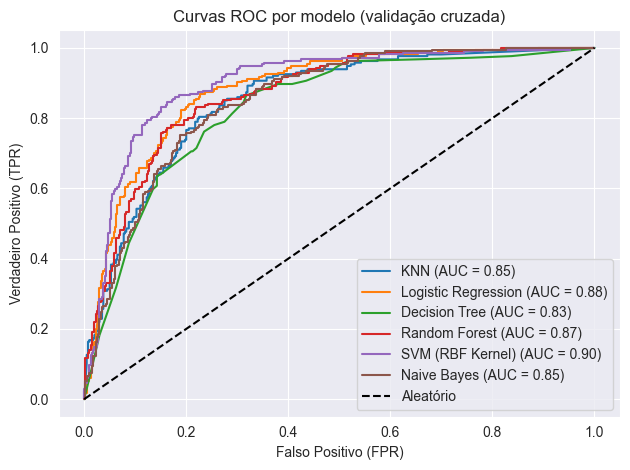

In [ ]:
from sklearn.model_selection import TunedThresholdClassifierCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict
import plotly.graph_objects as go

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'SVM (RBF Kernel)': SVC(probability=True, class_weight='balanced'),
    'Naive Bayes': GaussianNB()
}

param_grids = {
    'KNN': {
        'clf__n_neighbors': [3, 5, 7, 9, 11],
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['minkowski'],
        'clf__p': [1, 2]
    },
    'Logistic Regression': {
        'clf__C': [0.1, 1, 10],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    },
    'Decision Tree': {
        'clf__max_depth': [3, 5, 10, None],
        'clf__min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'clf__n_estimators': [50, 100],
        'clf__max_depth': [5, 10, None],
        'clf__min_samples_split': [2, 5]
    },
    'SVM (RBF Kernel)': {
        'clf__C': [0.1, 1, 10],
        'clf__gamma': ['scale', 'auto']
    },
    'Naive Bayes': {}
}
scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
}


results = []

best_overall_model = None
best_overall_score = -np.inf
best_overall_name = None

fig = go.Figure()
fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)

for name, model in models.items():
    basePipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])

    param_grid = param_grids.get(name, {})

    grid = GridSearchCV(basePipeline, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_pipeline = grid.best_estimator_
    best_params = grid.best_params_
    best_score = grid.best_score_

    tuned_model = TunedThresholdClassifierCV(
        estimator=best_pipeline,
        cv=cv,
        scoring='f1',
        random_state=42
    )

    tuned_model.fit(X_train, y_train)

    y_pred_proba = cross_val_predict(tuned_model, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]

    fpr, tpr, _ = roc_curve(y_train, y_pred_proba)
    auc = roc_auc_score(y_train, y_pred_proba)

    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=f'{name} (AUC = {auc:.2f})', mode='lines'))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

    if best_score > best_overall_score:
        best_overall_score = best_score
        best_overall_model = tuned_model
        best_overall_name = name

    scores = cross_validate(tuned_model, X_train, y_train, cv=cv, scoring=scoring)

    results.append({
        'Model': name,
        'Best Params': best_params,
        'Precision (median)': np.median(scores['test_precision']),
        'F1 (median)': np.median(scores['test_f1']),
        'Recall (median)': np.median(scores['test_recall']),
        'ROC AUC (median)': np.median(scores['test_roc_auc'])
    })

results_df = pd.DataFrame(results).sort_values(by='Recall (median)', ascending=False)
print(results_df)

results_melted = results_df.melt(id_vars=['Model'], value_vars=['Precision (median)', 'F1 (median)', 'ROC AUC (median)', 'Recall (median)'], var_name='Metric', value_name='Score')

fig = px.bar(results_melted, x='Model', y='Score', text='Score', title='Comparação de técnicas de pré processamento de dados',
                 labels={'Valor': 'Valor', 'Métrica': 'Métrica'}, color='Metric')
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.show()

print(f"Melhor valor de threshold: {best_overall_model.best_threshold_:.4f}")

plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlabel('Falso Positivo (FPR)')
plt.ylabel('Verdadeiro Positivo (TPR)')
plt.title('Curvas ROC por modelo (validação cruzada)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Significado de cada métrica análisada no gráfico de barras acima:

Accuracy:

- Útil para problemas considerados balanceados
- Percentual de previsões corretas
- Falsos positivos e falsos negativos têm impacto semelhante

F1:

- Útil para para equilibrar falsos positivos e negativos
- Média harmônica entre quantos dos positivos previstos estavam certos e quantos dos positivos reais foram encontrados


ROC AUC:

- Útil para avaliar a discriminabilidade geral do modelo
- Capacidade do modelo de separar classes (área entre 0 e 1, onde 1 é perfeito)


Recall:

- Útil para situações onde é inaceitável deixar passar um caso positivo
- Mede a proporção de verdadeiros positivos corretamente identificados






As métricas de maior interesse e significado ao projeto são F1 e RECALL, afinal, suas justificativas se adequam ao projeto. O F1 suporta bem o desequilibrio de classes e o Recall mede a proporção de verdadeiros positivos.

Também foram adicionadas na análise métricas não muito aderentes ao cenário do projeto (Accuracy e ROC AUC), com finalidade de comparar com as outras que acreditamos se adequar melhor ao interesse do estudo.

A partir das seleção dos quatro tipos de métricas acima e na criação de um gráfico de barras com as diferentes modelos classificatorios, observamos valores maiores de F1 e RECALL no SVM, que foi selecionado para as análises seguintes.





### 3.2 Avaliação do Modelo

In [ ]:
def evaluate_model(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred) * 100,
        'Precision': precision_score(y_true, y_pred) * 100,
        'Recall': recall_score(y_true, y_pred) * 100,
        'F1 Score': f1_score(y_true, y_pred) * 100,
    }

previsions = {}
resultados = {}

In [ ]:
y_pred_base = best_overall_model.predict(X_test)

previsions[best_overall_name] = y_pred_base
resultados[best_overall_name] = evaluate_model(y_test, y_pred_base)

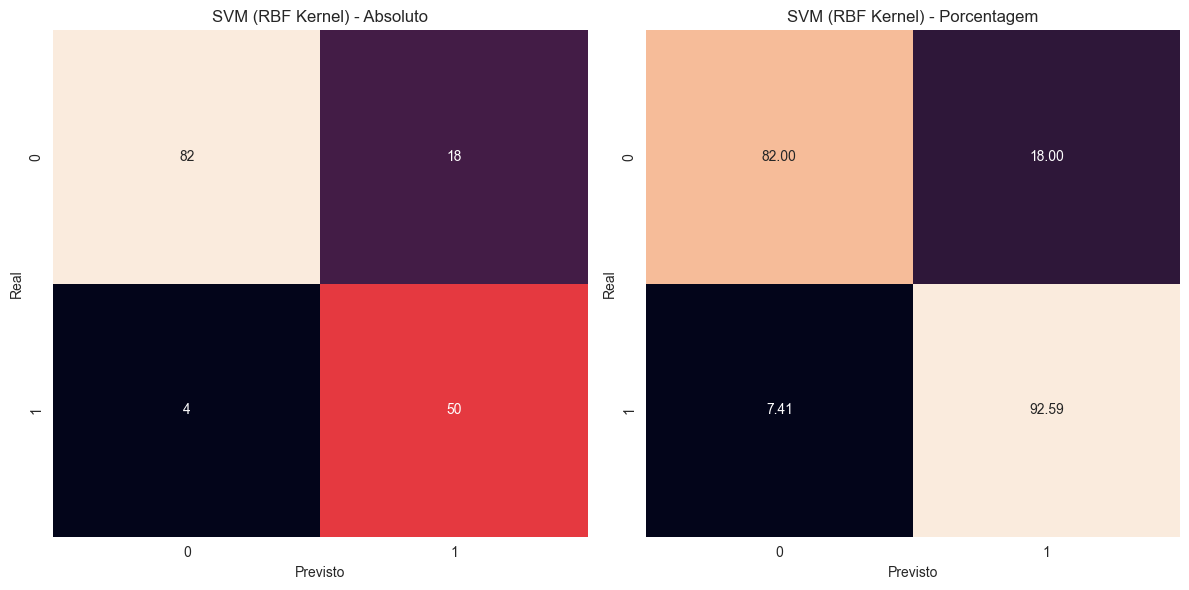

In [ ]:
df_resultados = pd.DataFrame(resultados).T.reset_index().rename(columns={'index': 'Abordagem'})
df_resultados = df_resultados.melt(id_vars='Abordagem', var_name='Métrica', value_name='Valor')

fig = px.bar(df_resultados, x='Abordagem', y='Valor', text='Valor', title='Resultado das Métricas', labels={'Valor (%)': 'Valor (%)', 'Métrica': 'Métrica'}, color='Métrica')
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.show()

# Recuperar nome e previsões
name, preds = next(iter(previsions.items()))

# Matrizes de confusão
cm_abs = confusion_matrix(y_true=y_test, y_pred=preds)
cm_pct = cm_abs.astype('float') / cm_abs.sum(axis=1)[:, np.newaxis] * 100

# Criar dois subplots lado a lado
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Plot absoluto
sns.heatmap(cm_abs, annot=True, fmt='d', cbar=False, ax=ax1)
ax1.set_title(f'{name} - Absoluto')
ax1.set_xlabel('Previsto')
ax1.set_ylabel('Real')

# Plot percentual
sns.heatmap(cm_pct, annot=True, fmt='.2f', cbar=False, ax=ax2)
ax2.set_title(f'{name} - Porcentagem')
ax2.set_xlabel('Previsto')
ax2.set_ylabel('Real')

plt.tight_layout()
plt.show()


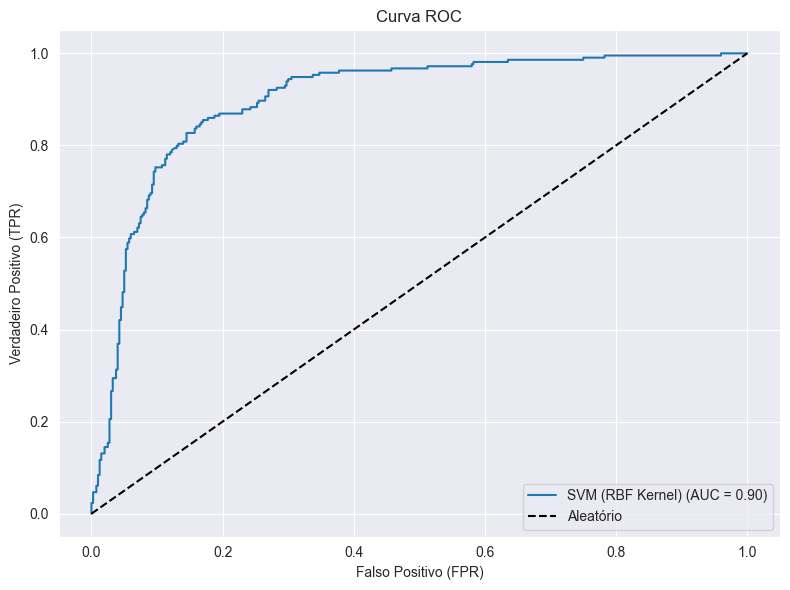

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = cross_val_predict(best_overall_model, X_train, y_train, cv=cv, method="predict_proba")[:, 1]
fpr, tpr, _ = roc_curve(y_train, y_pred_proba)
auc = roc_auc_score(y_train, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlabel('Falso Positivo (FPR)')
plt.ylabel('Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

A curva ROC representação a relação entre a taxa de verdadeiros positivos e a taxa de falsos positivos. No nosso caso o modelo tem uma AUC de 0,90.

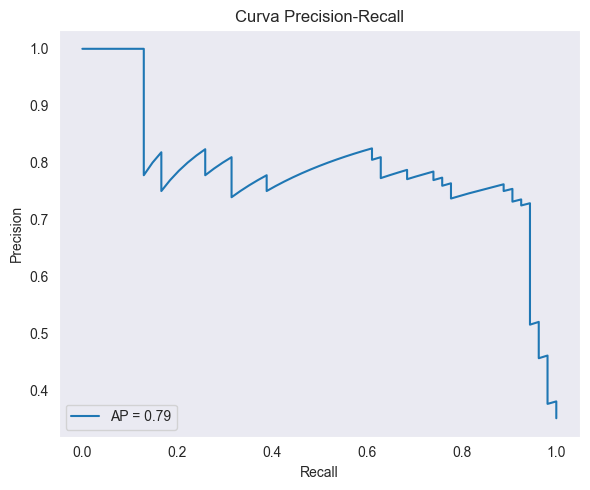

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_proba = best_overall_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap_score = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()

A Precision-Recall Curve é uma representação gráfica da relação entre a precisão e a revocação de um modelo de classificação. A precisão é a proporção de exemplos positivos classificados corretamente em relação a todos os exemplos classificados como positivos, enquanto a revocação é a proporção de exemplos positivos classificados corretamente em relação a todos os exemplos positivos no conjunto de dados. Em outras palavras, a Precision-Recall Curve mostra como a precisão e a revocação variam conforme alteramos o threshold de classificação do modelo.

Conclusão:

Com base nas análises obtidas concluimos que o modelo SVM se demonstra eficaz no diagnóstico de diabetes (seguindo as análises e calculos utilizados no projeto)

Foi necessário retirar os valores nulos
Substituir pela mediana.



- Threshold 0.35 é o mais interessante pois os valores de Recall e F1 Score são maiores
- Número de Falso-Positivos e Falso-Negativos são menores.


- É importante a opnião do Médico para opinar nos resultados, triagem e diagnostico precoce de diabates

apenas como auxiliar para o responsável na diagnosticação de diabétes.



### Além disso, ao final, escreva no relatório uma interpretação sobre os resultados, o que você entendeu, qual métrica é mais improtante analisar para o problema. E discuta se aqueles resultados estão bons, qual o melhor modelo e como o modelo seria usado na prática.




In [ ]:
### parte 1 - Dataset (Angelo)

### parte 2 - Pré-processamento de dados (Goiabeira)

### Parte 3 - Modelagem e treinamento (Angelo e Goiabeira)